In [1]:
from scipy.stats import norm
import time
import pandas as pd
import dask.dataframe as dd
import numpy as np
import feather
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler
from sklearn.metrics import *
from imblearn.metrics import classification_report_imbalanced
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
import configparser
import ast
import pickle
import sys
from multiprocessing import Pool, Process
import warnings
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV

config = configparser.ConfigParser()

config_path = config.read('/home/melgazar9/Trading/TD/Scripts/Trading-Scripts/CL/scripts/CL_10min_TRAIN-MODEL.ini'.format(sys.argv[1]))

print('**************** RUNNING', config['NAME']['product'], ' ****************')

train_start_date = config['PARAMS']['train_start_date']
train_end_date = config['PARAMS']['train_end_date']
val_start_date = config['PARAMS']['val_start_date']
val_end_date = config['PARAMS']['val_end_date']
test_start_date = config['PARAMS']['test_start_date']

threshold = float(config['PARAMS']['threshold'])
multiplier = float(config['PARAMS']['multiplier'])

strong_buy_actual = float(config['PARAMS']['strong_buy_actual'])
med_buy_actual = float(config['PARAMS']['med_buy_actual'])
no_trade_actual = float(config['PARAMS']['no_trade_actual'])
med_sell_actual = float(config['PARAMS']['med_sell_actual'])
strong_sell_actual = float(config['PARAMS']['strong_sell_actual'])
stop_actual = float(config['PARAMS']['stop_actual'])

strong_buy_HL = float(config['PARAMS']['strong_buy_HL'])
med_buy_HL = float(config['PARAMS']['med_buy_HL'])
no_trade_HL = float(config['PARAMS']['no_trade_HL'])
med_sell_HL = float(config['PARAMS']['med_sell_HL'])
strong_sell_HL = float(config['PARAMS']['strong_sell_HL'])
stop_HL = float(config['PARAMS']['stop_HL'])

strong_cap_actual = float(config['PARAMS']['strong_cap_actual'])
med_cap_actual = float(config['PARAMS']['med_cap_actual'])
strong_cap_HL = float(config['PARAMS']['strong_cap_HL'])
med_cap_HL = float(config['PARAMS']['med_cap_actual'])

min_prob0 = float(config['PARAMS']['min_prob0'])
min_prob1 = float(config['PARAMS']['min_prob1'])
min_prob3 = float(config['PARAMS']['min_prob3'])
min_prob4 = float(config['PARAMS']['min_prob4'])

min_prob_override0 = float(config['PARAMS']['min_prob_override0'])
min_prob_override1 = float(config['PARAMS']['min_prob_override1'])
min_prob_override3 = float(config['PARAMS']['min_prob_override3'])
min_prob_override4 = float(config['PARAMS']['min_prob_override4'])

Actual_Move = config['PARAMS']['Actual_Move_Name']
Actual_HighMove = config['PARAMS']['Actual_HighMove_Name']
Actual_LowMove = config['PARAMS']['Actual_LowMove_Name']

round_trip_fee = float(config['PARAMS']['round_trip_fee'])

if config['PARAMS']['read_csv'] == 'TRUE':
    print('Reading CSV...')
    ddf = dd.read_csv(config['PATH']['filename'])
elif config['PARAMS']['read_feather'] == 'TRUE':
    print('Reading Feather File...')
    # df = pd.read_feather(config['PATH']['filename'], use_threads=32)
    df = feather.read_dataframe(config['PATH']['filename'])
elif config['PARAMS']['read_parquet'] == 'TRUE':
    ddf = dd.read_parquet(config['PATH']['filename'])

df = ddf.compute()

try:
    df.set_index('Datetime', inplace=True)
except KeyError:
    print('Datetime index is already set!')
    pass


df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize('utc').tz_convert('US/Central')

df.dropna(axis=0, inplace=True)

df[Actual_Move] = df[['Prev' + Actual_Move.strip('Actual')]].resample(config['NAME']['product'][3:5] + 'min').first().rename(columns={'Prev' + Actual_Move.strip('Actual') : Actual_Move}).shift(-1)
df[Actual_HighMove] = df[['Prev' + Actual_HighMove.strip('Actual')]].resample(config['NAME']['product'][3:5] + 'min').first().rename(columns={'Prev' + Actual_HighMove.strip('Actual') : Actual_HighMove}).shift(-1)
df[Actual_LowMove] = df[['Prev' + Actual_LowMove.strip('Actual')]].resample(config['NAME']['product'][3:5] + 'min').first().rename(columns={'Prev' + Actual_LowMove.strip('Actual'): Actual_LowMove}).shift(-1)

df.head()

/home/melgazar9/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/melgazar9/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/melgazar9/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/melgazar9/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/melgazar9/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/melgazar9/anacon

**************** RUNNING CL_10min_  ****************
Datetime index is already set!


,Prev1minMove,Prev1minRange,Prev1minHighMove,Prev1minLowMove,Prev1minVolume,Prev2minMove,Prev2minRange,Prev2minHighMove,Prev2minLowMove,Prev2minVolume,...,Prev5minLowMove_Opinion,Prev10minMove_Opinion,Prev10minHighMove_Opinion,Prev10minLowMove_Opinion,Prev15minMove_Opinion,Prev15minHighMove_Opinion,Prev15minLowMove_Opinion,Actual10minMove,Actual10minHighMove,Actual10minLowMove
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 18:00:00-06:00,-0.05,0.05,0.00,-0.05,28.0,-0.04,0.08,0.04,-0.04,69.0,...,0,1,1,0,1,1,0,0.03,0.18,-0.17
2015-01-01 18:01:00-06:00,-0.07,0.12,0.02,-0.10,102.0,-0.04,0.08,0.04,-0.04,69.0,...,0,1,1,0,1,1,0,NaN,NaN,NaN
2015-01-01 18:02:00-06:00,0.00,0.11,0.00,-0.11,111.0,-0.06,0.19,0.02,-0.17,213.0,...,0,1,1,0,1,1,0,NaN,NaN,NaN
2015-01-01 18:03:00-06:00,0.23,0.29,0.29,0.00,156.0,-0.06,0.19,0.02,-0.17,213.0,...,0,1,1,0,1,1,0,NaN,NaN,NaN
2015-01-01 18:04:00-06:00,-0.04,0.11,0.02,-0.09,75.0,0.22,0.29,0.29,0.00,231.0,...,0,1,1,0,1,1,0,NaN,NaN,NaN


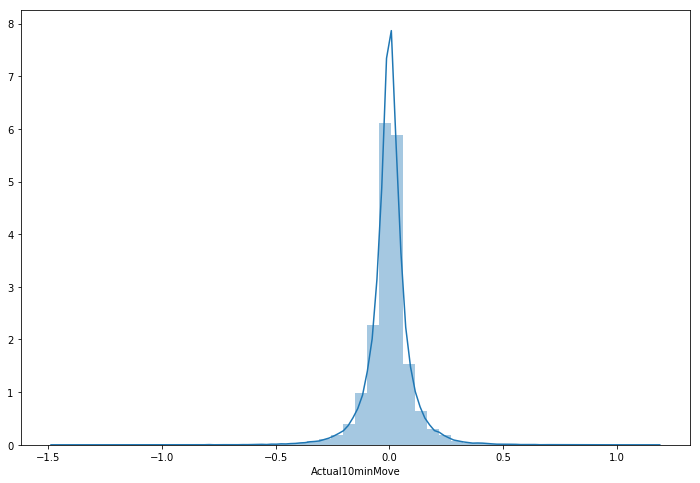

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(df['Actual10minMove'].dropna())

In [10]:
samp = df.sample(n=5000)
samp.head()

,Prev1minMove,Prev1minRange,Prev1minHighMove,Prev1minLowMove,Prev1minVolume,Prev2minMove,Prev2minRange,Prev2minHighMove,Prev2minLowMove,Prev2minVolume,...,Prev5minLowMove_Opinion,Prev10minMove_Opinion,Prev10minHighMove_Opinion,Prev10minLowMove_Opinion,Prev15minMove_Opinion,Prev15minHighMove_Opinion,Prev15minLowMove_Opinion,Actual10minMove,Actual10minHighMove,Actual10minLowMove
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-20 11:48:00-05:00,-0.03,0.07,0.02,-0.05,332.0,-0.02,0.07,0.03,-0.04,721.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2015-10-08 12:49:00-05:00,0.02,0.05,0.04,-0.01,262.0,-0.06,0.12,0.02,-0.10,862.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2017-05-19 09:09:00-05:00,-0.02,0.02,0.00,-0.02,779.0,-0.03,0.07,0.01,-0.06,2087.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2015-11-10 14:52:00-06:00,-0.01,0.01,0.00,-0.01,16.0,-0.01,0.02,0.01,-0.01,59.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2016-12-30 06:12:00-06:00,-0.03,0.04,0.01,-0.03,229.0,-0.04,0.05,0.01,-0.04,446.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN


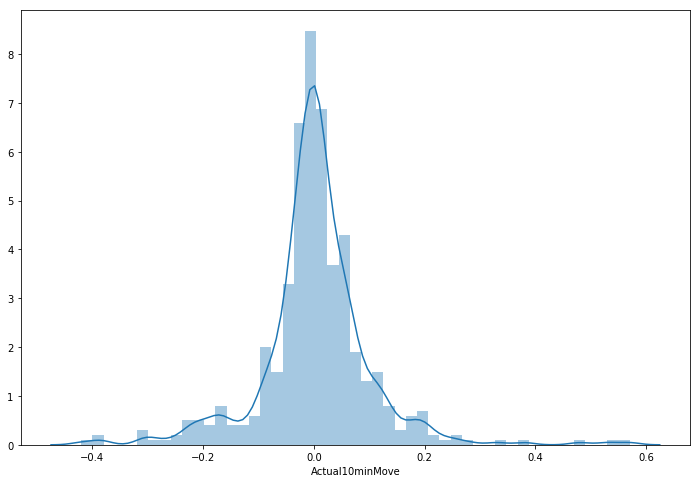

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(samp['Actual10minMove'].dropna())

In [20]:
mu = df['Actual10minMove'].mean()
sigma = df['Actual10minMove'].std()
x_bar = samp['Actual10minMove'].mean()

s = samp['Actual10minMove'].std()

Z = (x_bar - mu) / (s/np.sqrt(len(samp)))
mu, x_bar, sigma, s, Z

(-0.00048267668443202725,
 0.0028830645161289957,
 0.09600879930864184,
 0.10098481951865855,
 2.356728900422424)

In [25]:
norm.cdf(Z)

0.9907816494804071

In [28]:
norm.sf(Z)

0.009218350519592907

In [27]:
norm.cdf(Z) + norm.sf(Z)

1.0

In [40]:
from statsmodels.stats.weightstats import ztest

ztest(samp['Actual10minMove'].dropna(), df['Actual10minMove'].dropna(), value=0, alternative='two-sided')

(0.7789615510370191, 0.43600236418417215)

In [47]:
(x_bar - Z*(s/np.sqrt(len(samp))), x_bar + Z*(s/np.sqrt(len(samp))))

(-0.00048267668443202714, 0.006248805716690019)

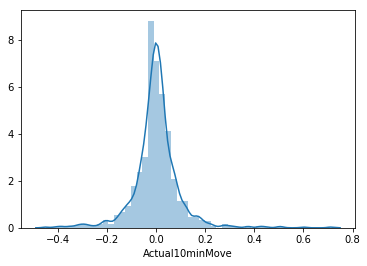

In [55]:
sns.distplot(df['Actual10minMove'].sample(n=10000).dropna())

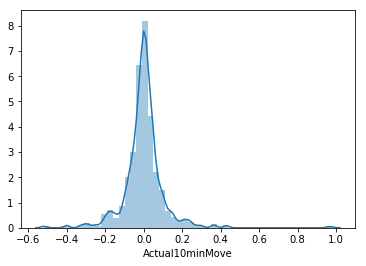

In [56]:
sns.distplot(df['Actual10minMove'].sample(n=10000).dropna())

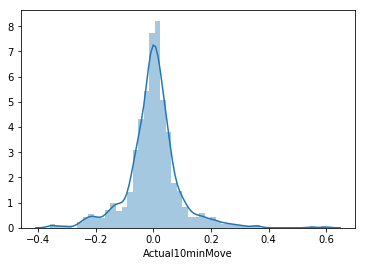

In [57]:
sns.distplot(df['Actual10minMove'].sample(n=10000).dropna())

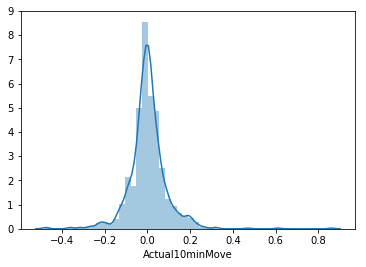

In [58]:
sns.distplot(df['Actual10minMove'].sample(n=10000).dropna())

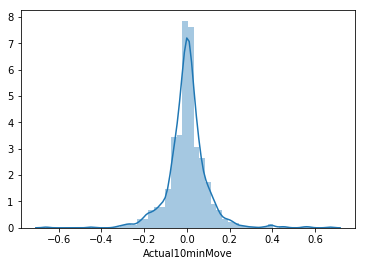

In [59]:
sns.distplot(df['Actual10minMove'].sample(n=10000).dropna())